In [330]:
import torch.nn as nn
import pickle
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [301]:
with open("test_sartorius_mask_crnn_big_101.pickle", "rb") as handle:
    results = pickle.load(handle)
    results = results[1]

In [153]:
with open("test_sartorius_mask_rcnn_small.pickle", "rb") as handle:
    results = pickle.load(handle)
    results = results[1]

In [7]:
files = ['dataset/test/7ae19de7bc2a.png', 'dataset/test/d48ec7815252.png', 'dataset/test/d8bfd1dafdc4.png']
ids = [file.split('/')[-1].split(".")[0] for file in files]

In [306]:
ids

['7ae19de7bc2a', 'd48ec7815252', 'd8bfd1dafdc4']

In [187]:
current_file = 1

In [314]:
class0[0].shape

(520, 704)

In [228]:
confidences = [numpy.sum(el, axis=1) for el in results[current_file][0]]

In [219]:
class0 = results[current_file][1][0] if len(results[current_file][1][0]) > 1 else []
class1 = results[current_file][1][1] if len(results[current_file][1][1]) > 1 else []
class2 = results[current_file][1][2] if len(results[current_file][1][2]) > 1 else []

In [221]:
if len(class0) != 0:
    or_class0 = class0[0]
    for el in class0[1:]:
        or_class0 = numpy.bitwise_or(or_class0, el)
else:
    or_class0 = [[]]

if len(class1) != 0:
    or_class1 = class1[0]
    for el in class1[1:]:
        or_class1 = numpy.bitwise_or(or_class1, el)
else:
    or_class1 = [[]]
        
if len(class2) != 0:
    or_class2 = class2[0]
    for el in class2[1:]:
        or_class2 = numpy.bitwise_or(or_class2, el)
else:
    or_class2 = [[]]

In [294]:
class0_confident = [element.astype(float) * confidences[0][index] for index, element in enumerate(class0)]
class1_confident = [element.astype(float) * confidences[1][index] for index, element in enumerate(class1)]
class2_confident = [element.astype(float) * confidences[2][index] for index, element in enumerate(class2)]

100

In [295]:
cell_confident = class0_confident + class1_confident + class2_confident
for x in range(cell_confident[0].shape[0]):
    for y in range(cell_confident[0].shape[1]):
        max_index = 0
        max_value = cell_confident[0][x][y]
        for index, element in enumerate(cell_confident[1:]):
            if element[x][y] > max_value:
                max_index = index + 1
                max_value = element[x][y]
        for index, element in enumerate(cell_confident):
            if max_index != index:
                element[x][y] = 0
            else:
                element[x][y] = min(1, element[x][y])
cell_confident = [element.astype(bool) for element in cell_confident]

In [299]:
def compute_confidence(current_file):
    class0 = results[current_file][1][0] if len(results[current_file][1][0]) > 1 else []
    class1 = results[current_file][1][1] if len(results[current_file][1][1]) > 1 else []
    class2 = results[current_file][1][2] if len(results[current_file][1][2]) > 1 else []
    confidences = [numpy.sum(el, axis=1) for el in results[current_file][0]]
    class0_confident = [element.astype(float) * confidences[0][index] for index, element in enumerate(class0)]
    class1_confident = [element.astype(float) * confidences[1][index] for index, element in enumerate(class1)]
    class2_confident = [element.astype(float) * confidences[2][index] for index, element in enumerate(class2)]
    cell_confident = class0_confident + class1_confident + class2_confident
    for x in range(cell_confident[0].shape[0]):
        for y in range(cell_confident[0].shape[1]):
            max_index = 0
            max_value = cell_confident[0][x][y]
            for index, element in enumerate(cell_confident[1:]):
                if element[x][y] > max_value:
                    max_index = index + 1
                    max_value = element[x][y]
            for index, element in enumerate(cell_confident):
                if max_index != index:
                    element[x][y] = 0
                else:
                    element[x][y] = min(1, element[x][y])
    cell_confident = [element.astype(bool) for element in cell_confident]
    return cell_confident

In [338]:
def run_length_encode(id: str, masks):
    rles = []
    sizes = numpy.array([numpy.sum(el) for el in masks])
    std_sizes = numpy.std(sizes)
    mean = numpy.mean(sizes)
    print(f"mean: {mean}")
    print(f"std: {std_sizes}")
    print(f"threshold: {(mean - 2 * std_sizes)}")
    for mask in masks:
        rle = []
        start = 0
        in_mask = False
        flat_mask = mask.transpose().flatten()
        if numpy.sum(flat_mask) <= max(mean - 2 * std_sizes, 10):
            print("skipped")
            continue
        for index, el in enumerate(flat_mask):
            if el:
                if not in_mask:
                    in_mask = True
                    start = index
                if index == len(flat_mask) - 1 or not flat_mask[index + 1]:
                    rle.append(str(start + 1))
                    rle.append(str(index - start + 2))
            else:
                in_mask = False
                    
        rles.append(" ".join(rle))
    return pd.DataFrame.from_dict({
        "id": [id for _ in rles],
        "predicted": rles
    })

In [339]:
result = None
for current_file, id in enumerate(ids):
    result_pd = run_length_encode(id, compute_confidence(current_file))
    if not result is None:
        result = result.append(result_pd, ignore_index=True)
    else:
        result = result_pd

mean: 238.49
std: 96.73029463410106
threshold: 45.029410731797896
skipped
mean: 530.38
std: 556.6270704879526
threshold: -582.8741409759051
skipped
skipped
skipped
skipped
skipped
skipped
skipped
mean: 772.58
std: 567.516099859731
threshold: -362.4521997194619
skipped


In [312]:
result

,id,predicted
0,7ae19de7bc2a,140245 6 140949 7 141652 8 142356 9 143060 9 1...
1,7ae19de7bc2a,165017 5 165718 12 166416 21 167119 23 167824 ...
2,7ae19de7bc2a,156298 5 156999 8 157700 11 158403 12 159106 1...
3,7ae19de7bc2a,255859 11 256563 14 257266 17 257970 19 258675...
4,7ae19de7bc2a,150340 5 151041 10 151743 13 152446 15 153148 ...
...,...,...
286,d8bfd1dafdc4,131870 19 131903 3 132570 42 133272 45 133975 ...
287,d8bfd1dafdc4,1057 14 1760 17 2464 20 3169 21 3874 21 4578 7...
288,d8bfd1dafdc4,54968 3 55670 16 56372 30 57074 34 57778 36 58...
289,d8bfd1dafdc4,115535 1 116237 1 116939 1 117639 2 118340 3 1...


In [345]:
result.to_csv("predictions_big_cascade_rcnn_101.csv", index=False)

In [340]:
def convert_to_masks(predictions_table):
    results = []
    for _, picture_group in predictions_table.groupby('id'):
        picture_id = picture_group.iloc[0]['id']
        picture_size = 704*520
        cell_array = numpy.zeros(picture_size, dtype=int)
        for index, cell in picture_group.iterrows():
            predicted = [int(val) for val in cell['predicted'].split(' ')]
            for index in range(0, len(predicted), 2):
                cell_array[predicted[index] - 1:predicted[index]+predicted[index+1] - 1 - 1] += 1
        results.append(cell_array.reshape(704, 520).transpose())
    return results

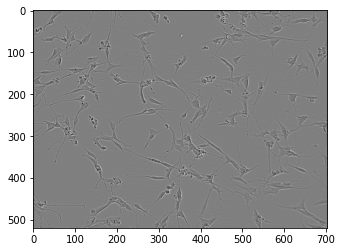

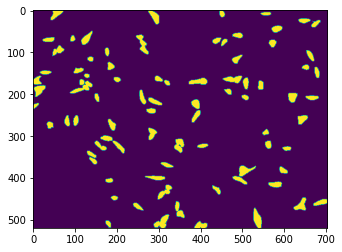

In [341]:

plt.imshow(cv2.imread(files[0]))
plt.show()
plt.imshow(convert_to_masks(result)[0])

In [344]:
convert_to_masks(result)[2].max()

1

In [4]:
config = '/home/max/.local/lib/python3.9/site-packages/mmdet/.mim/configs/cascade_rcnn/cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco.py'
model = init_detector(config, device='cpu')


In [10]:
from monai.networks.nets.unetr import UNETR
import torch
from torch.nn.modules.loss import CrossEntropyLoss
from bigkingxxl.discriminator.discriminator import Discriminator
from bigkingxxl.evaluator.evalutator import label_instances
from bigkingxxl.loss.IoULoss import IoULoss
from bigkingxxl.trainer.gan_trainer import GanTrainer
from bigkingxxl.dataset.dataset import SartoriusDataset
from torch.optim import Adam
from torch.nn import BCELoss
from torch.utils.data import DataLoader
import logging
import matplotlib.pyplot as plt

DEVICE = 'cuda'
SAVE = 'models/2021_11_29_22_39_19_014861/epoch_6_'

def main(device: str = DEVICE):
    # define generator and discriminator
    #generator = UNETR(in_channels=1, out_channels=1, img_size=(520, 704), spatial_dims=2)
    generator = UNETR(in_channels=1, out_channels=3, img_size=(512, 704), spatial_dims=2).to(device)
    discriminator = Discriminator((4, 512, 704)).to(device)
    
    generator.load_state_dict(torch.load(SAVE + 'generator.pth'))

    train_dataset = SartoriusDataset(dataset_path = './dataset', mode = 'train')
    train_dataloader = DataLoader(train_dataset)
    # define test data
    test_dataset = SartoriusDataset(dataset_path = './dataset', mode = 'test')
    test_dataloader = DataLoader(test_dataset)

    for inputImage, maskImage in test_dataloader:
        inputImage = inputImage[:, :512, :].reshape(-1, 1, 512, 704).float().to(device)
        maskImage = maskImage[:, :, :512,:].reshape(-1, 3, 512, 704).float().to(device)
        predictedMask = generator(inputImage).reshape(3, 512, 704)
        plt.imshow(predictedMask.permute(1, 2, 0))
        plt.show()
        label_instances(predictedMask)


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO)
    main()

CascadeRCNN(
  (backbone): ResNeXt(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S